## Load Module Files from GitHub

In [1]:
!rm /content/*.py*

rm: cannot remove '/content/*.py*': No such file or directory


In [2]:
queries = []

filenames = [
             "Conv2DMHAUnit.py",
             "Conv2DmhaLSTMCell.py",
             "conv2d_mha_utils.py"
]

for fn in filenames:
  queries.append(f"https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/Conv2DAttentionLSTM/{fn}")
queries.append("https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/imports.py")

In [3]:
queries

['https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/Conv2DAttentionLSTM/Conv2DMHAUnit.py',
 'https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/Conv2DAttentionLSTM/Conv2DmhaLSTMCell.py',
 'https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/Conv2DAttentionLSTM/conv2d_mha_utils.py',
 'https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/imports.py']

In [4]:
import subprocess
# Download and import my module files from GitHub
result = subprocess.run(["wget", "--no-cache", "--backups=1"] + queries, stderr=subprocess.PIPE, stdout=subprocess.PIPE)
print(result.stderr.decode("utf-8"))

--2022-07-28 16:41:57--  https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/Conv2DAttentionLSTM/Conv2DMHAUnit.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3980 (3.9K) [text/plain]
Failed to rename Conv2DMHAUnit.py to Conv2DMHAUnit.py.1: (2) No such file or directory
Saving to: ‘Conv2DMHAUnit.py’

     0K ...                                                   100% 52.7M=0s

2022-07-28 16:41:57 (52.7 MB/s) - ‘Conv2DMHAUnit.py’ saved [3980/3980]

--2022-07-28 16:41:57--  https://raw.githubusercontent.com/NuoWenLei/MultimodalFusionWithUnorthodoxInputs/main/Conv2DAttentionLSTM/Conv2DmhaLSTMCell.py
Reusing existing connection to raw.githubusercontent.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 2628 (2.6K)

## Load Google Drive Files

In [5]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
unscaled_maps_path = "/content/gdrive/MyDrive/Inspirit AI/Inspirit_Research_Project/covid_map_data/infection_maps_unscaled.npy"
unscaled_metadata_path = "/content/gdrive/MyDrive/Inspirit AI/Inspirit_Research_Project/covid_map_data/infection_unscaled_metadata.json"
scaled_maps_path = "/content/gdrive/MyDrive/Inspirit AI/Inspirit_Research_Project/covid_map_data/infection_maps_scaled.npy"
scaled_metadata_path = "/content/gdrive/MyDrive/Inspirit AI/Inspirit_Research_Project/covid_map_data/infection_scaled_metadata.json"
dataset_path = "/content/gdrive/MyDrive/Inspirit AI/Inspirit_Research_Project/US_time_series_covid_cases.csv"

## Hyperparamters

In [7]:
BATCH_SIZE = 16

EPOCHS = 10
IMAGE_X, IMAGE_Y = 64, 64
NUM_DAYS_PER_SAMPLE = 7

In [8]:
from conv2d_mha_utils import load_sequential_data, create_flow, create_conv_mha_lstm_model, tf

# Unscaled Maps

## Load Sequential Data

In [9]:
X_indices, y_infection, y_death, X_maps = load_sequential_data(
    maps_path = unscaled_maps_path,
    metadata_path = unscaled_metadata_path,
    dataset_path = dataset_path,
    image_x = IMAGE_X,
    image_y = IMAGE_Y,
    num_days_per_sample = NUM_DAYS_PER_SAMPLE
)

Loading Image Indices...


41993it [00:01, 24228.98it/s]


In [10]:
X_maps.shape

(857, 64, 64, 1)

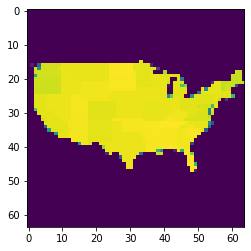

In [11]:
import matplotlib.pyplot as plt

plt.imshow(X_maps[600].squeeze())

## Load Model

In [12]:
MODEL_ARCHITECTURE = (16, 16, 16)
NUM_HEADS = 8
D_MODEL = 32
OUTPUT_SIZE = 49
IMAGE_DIMS = (IMAGE_X, IMAGE_Y, 1)
KERNEL_SIZE = (4, 4)

In [13]:
conv_attention_lstm = create_conv_mha_lstm_model(
    layer_units = MODEL_ARCHITECTURE,
    num_heads = NUM_HEADS,
    d_model = D_MODEL,
    output_size = OUTPUT_SIZE,
    image_dims = IMAGE_DIMS,
    kernel_size = KERNEL_SIZE,
    sequence_length = NUM_DAYS_PER_SAMPLE
)

## Split Train Test

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_indices, y_infection, train_size = 0.8, random_state = 0)

In [16]:
gen_test = create_flow(X_train, y_train, BATCH_SIZE, X_maps)

In [17]:
X_samp, y_samp = next(gen_test)

In [18]:
X_samp.shape, y_samp.shape

((16, 7, 64, 64, 1), (16, 49))

## Component Construction

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

@tf.function
def loss_func(y_true, y_pred):
  squared_diff = tf.square(y_true - y_pred)
  mse = tf.reduce_mean(squared_diff, axis=-1)
  squared_diff_mean = tf.square(tf.reduce_mean(y_true, axis = -1) - tf.reduce_mean(y_pred, axis = -1))
  return mse + squared_diff_mean

conv_attention_lstm.compile(
    loss = loss_func,
    optimizer = opt,
    metrics = ["mse", "mae"]
)

In [20]:
conv_attention_lstm.summary()

Model: "Conv2DAttentionLSTMModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 64, 64, 1)]    0         
                                                                 
 rnn (RNN)                   (None, 7, 64, 64, 32)     13440     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 32, 32, 32)    0         
 )                                                               
                                                                 
 rnn_1 (RNN)                 (None, 7, 32, 32, 32)     25344     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 16, 16, 32)    0         
 3D)                                                             
                                                                 
 rnn_2 (RNN)                 (None, 16, 16

In [21]:
train_generator = create_flow(X_train, y_train, BATCH_SIZE, X_maps)

## Train Model

In [22]:
EPOCHS = 20

BATCH_SIZE = 16

STEPS_PER_EPOCH = X_train.shape[0] // BATCH_SIZE

history = conv_attention_lstm.fit(
    x = train_generator,
    batch_size = BATCH_SIZE,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS
    )

Epoch 1/20
42/42 [==============================] - 135s 2s/step - loss: 4.9150e-05 - mse: 4.6781e-05 - mae: 0.0041
Epoch 2/20
42/42 [==============================] - 94s 2s/step - loss: 2.3205e-06 - mse: 1.3926e-06 - mae: 9.5493e-04
Epoch 3/20
42/42 [==============================] - 94s 2s/step - loss: 1.9604e-06 - mse: 1.0366e-06 - mae: 8.5009e-04
Epoch 4/20
42/42 [==============================] - 94s 2s/step - loss: 1.9823e-06 - mse: 1.0442e-06 - mae: 8.5156e-04
Epoch 5/20
42/42 [==============================] - 94s 2s/step - loss: 2.0357e-06 - mse: 1.0939e-06 - mae: 8.5899e-04
Epoch 6/20
42/42 [==============================] - 94s 2s/step - loss: 1.9718e-06 - mse: 1.0414e-06 - mae: 8.5303e-04
Epoch 7/20
42/42 [==============================] - 94s 2s/step - loss: 2.0359e-06 - mse: 1.0776e-06 - mae: 8.5964e-04
Epoch 8/20
42/42 [==============================] - 94s 2s/step - loss: 2.0285e-06 - mse: 1.0690e-06 - mae: 8.5365e-04
Epoch 9/20
42/42 [==============================] -

In [23]:
test_generator = create_flow(X_test, y_test, BATCH_SIZE, X_maps)

In [24]:
STEPS = X_test.shape[0] // BATCH_SIZE

In [25]:
conv_attention_lstm.evaluate(x = test_generator, steps = STEPS, batch_size = BATCH_SIZE)

10/10 [==============================] - 13s 808ms/step - loss: 2.0239e-06 - mse: 1.0677e-06 - mae: 8.5929e-04


[2.0239140212652273e-06, 1.0677172213036101e-06, 0.0008592939702793956]